# Volume-Adjusted $\tau$-Reset Liquidity Strategy

In [65]:
from typing import List
from dataclasses import dataclass
import numpy as np
import pandas as pd
from fractal.core.base import Observation
from fractal.core.entities import UniswapV3LPGlobalState



from datetime import datetime, UTC

@dataclass
class VolumeAdjustedParams:
    TAU: int
    BASE_DELTA: float
    K: float
    FEE: float
    INITIAL_BALANCE: float
    VOLUME_WINDOW: int = 24

class VolumeAdjustedTauResetStrategy:
    def __init__(self, params: VolumeAdjustedParams, debug: bool = False):
        self.params = params
        self.debug = debug
        self.results = []

    def run(self, observations: List[Observation]):
        balance = self.params.INITIAL_BALANCE
        last_reset = None
        liquidity = 0
        current_price = None
        volume_series = []

        for i, obs in enumerate(observations):
            ts = obs.timestamp
            state: UniswapV3LPGlobalState = obs.states['UNISWAP_V3']
            price = state.price
            volume = state.volume
            volume_series.append(volume)

            if i < self.params.VOLUME_WINDOW:
                self.results.append({"timestamp": ts, "price": price, "balance": balance})
                continue

            if last_reset is None or (ts - last_reset).total_seconds() >= self.params.TAU * 3600:
                recent_volumes = volume_series[-self.params.VOLUME_WINDOW:]
                volume_mean = np.mean(recent_volumes)
                volume_rel = volume / volume_mean if volume_mean > 0 else 1.0

                delta = self.params.BASE_DELTA + self.params.K * (volume_rel - 1)
                delta = np.clip(delta, 0.01, 0.2)

                if current_price is not None:
                    ratio = price / current_price
                    il = (2 * np.sqrt(ratio) / (1 + ratio)) - 1
                    balance *= (1 + il)

                lower = price * (1 - delta)
                upper = price * (1 + delta)
                sqrt_diff = np.sqrt(upper) - np.sqrt(lower)
                liquidity = balance / sqrt_diff
                balance -= liquidity * self.params.FEE  # комиссия

                last_reset = ts
                current_price = price

                if self.debug:
                    print(f"[{ts}] Δ={delta:.3f}, Volume={volume:.0f}, New LP={liquidity:.2f}, Balance={balance:.2f}")

            self.results.append({"timestamp": ts, "price": price, "balance": balance})

        return self

    def to_dataframe(self):
        return pd.DataFrame(self.results).set_index("timestamp")

    def get_default_metrics(self):
        df = self.to_dataframe()
        returns = df["balance"].pct_change().dropna()
        pnl = df["balance"].iloc[-1] / df["balance"].iloc[0] - 1
        sharpe = returns.mean() / returns.std() * np.sqrt(365 * 24 / self.params.TAU) if not returns.empty else 0
        mdd = (df["balance"] / df["balance"].cummax() - 1).min()
        return {
            "PnL (%)": round(pnl * 100, 2),
            "Sharpe": round(sharpe, 2),
            "Max Drawdown (%)": round(mdd * 100, 2)
        }

# Volume-Volatility Adjusted 𝜏-reset strategy

In [66]:
@dataclass
class CombinedParams:
    TAU: int
    BASE_DELTA: float
    KV: float
    KSIGMA: float
    FEE: float
    INITIAL_BALANCE: float
    WINDOW: int = 24

class VolumeVolatilityTauResetStrategy:
    def __init__(self, params: CombinedParams, debug=False):
        self.params = params
        self.debug = debug
        self.results = []

    def run(self, observations: List[Observation]):
        balance = self.params.INITIAL_BALANCE
        last_reset = None
        liquidity = 0
        current_price = None

        price_series = []
        volume_series = []

        for i, obs in enumerate(observations):
            ts = obs.timestamp
            state: UniswapV3LPGlobalState = obs.states['UNISWAP_V3']
            price = state.price
            volume = state.volume

            price_series.append(price)
            volume_series.append(volume)

            if i < self.params.WINDOW:
                self.results.append({"timestamp": ts, "price": price, "balance": balance})
                continue

            if last_reset is None or (ts - last_reset).total_seconds() >= self.params.TAU * 3600:
                vol_window = np.array(volume_series[-self.params.WINDOW:])
                price_window = np.array(price_series[-self.params.WINDOW:])
                mean_volume = np.mean(vol_window)
                mean_sigma = np.std(price_window)

                vol_rel = volume / mean_volume if mean_volume > 0 else 1.0
                sigma_rel = np.std(price_window[-5:]) / mean_sigma if mean_sigma > 0 else 1.0

                delta = self.params.BASE_DELTA + self.params.KV * (vol_rel - 1) + self.params.KSIGMA * (sigma_rel - 1)
                delta = np.clip(delta, 0.01, 0.2)

                if current_price is not None:
                    ratio = price / current_price
                    il = (2 * np.sqrt(ratio) / (1 + ratio)) - 1
                    balance *= (1 + il)

                lower = price * (1 - delta)
                upper = price * (1 + delta)
                sqrt_diff = np.sqrt(upper) - np.sqrt(lower)
                liquidity = balance / sqrt_diff
                balance -= liquidity * self.params.FEE

                last_reset = ts
                current_price = price

                if self.debug:
                    print(f"[{ts}] Δ={delta:.3f}, Volume={volume:.0f}, σ_rel={sigma_rel:.2f}, New LP={liquidity:.2f}, Balance={balance:.2f}")

            self.results.append({"timestamp": ts, "price": price, "balance": balance})

        return self

    def to_dataframe(self):
        return pd.DataFrame(self.results).set_index("timestamp")

    def get_default_metrics(self):
        df = self.to_dataframe()
        returns = df["balance"].pct_change().dropna()
        pnl = df["balance"].iloc[-1] / df["balance"].iloc[0] - 1
        sharpe = returns.mean() / returns.std() * np.sqrt(365 * 24 / self.params.TAU) if not returns.empty else 0
        mdd = (df["balance"] / df["balance"].cummax() - 1).min()
        return {
            "PnL (%)": round(pnl * 100, 2),
            "Sharpe": round(sharpe, 2),
            "Max Drawdown (%)": round(mdd * 100, 2)
        }

# Get historical data

In [13]:
def get_observations(
        pool_data: PoolHistory, price_data: PriceHistory,
        start_time: datetime = None, end_time: datetime = None
    ) -> List[Observation]:
    """
    Get observations from the pool and price data for the TauResetStrategy.

    Returns:
        List[Observation]: The observation list for TauResetStrategy.
    """
    observations_df: pd.DataFrame = pool_data.join(price_data)
    observations_df = observations_df.dropna()
    observations_df = observations_df.loc[start_time:end_time]
    if start_time is None:
        start_time = observations_df.index.min()
    if end_time is None:
        end_time = observations_df.index.max()
    observations_df = observations_df[observations_df.tvl > 0]
    observations_df = observations_df.sort_index()
    return [
        Observation(
            timestamp=timestamp,
            states={
                'UNISWAP_V3': UniswapV3LPGlobalState(price=price, tvl=tvls, volume=volume, fees=fees, liquidity=liquidity),
            }
        ) for timestamp, (tvls, volume, fees, liquidity, price) in observations_df.iterrows()
    ]

In [14]:
def build_observations(
        ticker: str, pool_address: str, api_key: str,
        start_time: datetime = None, end_time: datetime = None, fidelity: str = 'hour',
    ) -> List[Observation]:
    """
    Build observations for the TauResetStrategy from the given start and end time.
    """
    if fidelity == 'hour':
        pool_data: PoolHistory = UniswapV3EthereumPoolHourDataLoader(
            api_key, pool_address, loader_type=LoaderType.CSV).read(with_run=True)
        binance_prices: PriceHistory = BinanceHourPriceLoader(ticker, loader_type=LoaderType.CSV).read(with_run=True)
    elif fidelity == 'minute':
        pool_data: PoolHistory = UniswapV3EthereumPoolMinuteDataLoader(
            api_key, pool_address, loader_type=LoaderType.CSV).read(with_run=True)
        binance_prices: PriceHistory = BinanceMinutePriceLoader(ticker, loader_type=LoaderType.CSV,
                                                                start_time=start_time, end_time=end_time).read(with_run=True)
    else:
        raise ValueError("Fidelity must be either 'hour' or 'minute'.")
    return get_observations(pool_data, binance_prices, start_time, end_time)

In [24]:
from dotenv import load_dotenv
import os

from fractal.loaders.base_loader import LoaderType
from fractal.loaders.thegraph.uniswap_v3 import (
    UniswapV3EthereumPoolHourDataLoader, EthereumUniswapV3Loader, UniswapV3EthereumPoolMinuteDataLoader
)
from fractal.loaders.binance import BinanceHourPriceLoader, BinanceMinutePriceLoader
from fractal.loaders.structs import PriceHistory, PoolHistory

from fractal.core.base import Observation
from fractal.strategies.tau_reset_strategy import TauResetParams, TauResetStrategy


load_dotenv()
THE_GRAPH_API_KEY = os.getenv('THE_GRAPH_API_KEY')
ticker: str = 'ETHUSDT'
pool_address: str = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'
THE_GRAPH_API_KEY = THE_GRAPH_API_KEY

# Load data
token0_decimals, token1_decimals = EthereumUniswapV3Loader(
THE_GRAPH_API_KEY, loader_type=LoaderType.CSV).get_pool_decimals(pool_address)

observations: List[Observation] = build_observations(
    ticker=ticker, pool_address=pool_address, api_key=THE_GRAPH_API_KEY,
    start_time=datetime(2025, 1, 11, tzinfo=UTC), end_time=datetime(2025, 2, 11, tzinfo=UTC),
    fidelity='hour'
)

/app/venv/lib/python3.12/site-packages/fractal/loaders/thegraph/uniswap_v3/uniswap_v3_pool.py:153: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self._data = self._data.resample('H').ffill()
/app/venv/lib/python3.12/site-packages/fractal/loaders/thegraph/uniswap_v3/uniswap_v3_pool.py:153: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  self._data = self._data.resample('H').ffill()


# Volume adj

In [79]:
params = VolumeAdjustedParams(
    TAU=24,
    BASE_DELTA=0.07,
    K=0.05,
    FEE=0.003,
    INITIAL_BALANCE=1_000_000
)

In [80]:
params = VolumeAdjustedParams(
    TAU=24,
    BASE_DELTA=0.05,
    K=0.1,
    FEE=0.003,
    INITIAL_BALANCE=1_000_000
)

In [81]:
strategy = VolumeAdjustedTauResetStrategy(params=params, debug=True)
result = strategy.run(observations)

df = result.to_dataframe()
df.to_csv("volume_adjusted_tau_result.csv")

print(result.get_default_metrics())

[2025-01-12 00:00:00+00:00] Δ=0.096, Volume=114487, New LP=181446.33, Balance=999455.66
[2025-01-13 00:00:00+00:00] Δ=0.200, Volume=740037, New LP=86452.64, Balance=999188.94
[2025-01-14 00:00:00+00:00] Δ=0.010, Volume=208808, New LP=1784564.59, Balance=993466.69
[2025-01-15 00:00:00+00:00] Δ=0.087, Volume=290176, New LP=201608.55, Balance=992767.50
[2025-01-16 00:00:00+00:00] Δ=0.036, Volume=249126, New LP=468117.99, Balance=991004.64
[2025-01-17 00:00:00+00:00] Δ=0.042, Volume=227953, New LP=411528.08, Balance=989690.22
[2025-01-18 00:00:00+00:00] Δ=0.140, Volume=450491, New LP=119486.30, Balance=989011.10
[2025-01-19 00:00:00+00:00] Δ=0.152, Volume=951960, New LP=112672.04, Balance=988363.53
[2025-01-20 00:00:00+00:00] Δ=0.047, Volume=923882, New LP=371932.75, Balance=986999.80
[2025-01-21 00:00:00+00:00] Δ=0.010, Volume=350596, New LP=1737628.52, Balance=981749.50
[2025-01-22 00:00:00+00:00] Δ=0.010, Volume=163409, New LP=1692927.09, Balance=976463.36
[2025-01-23 00:00:00+00:00] Δ=

# Combined strat: Volatility + Volume

In [78]:
params = CombinedParams(
    TAU=24,
    BASE_DELTA=0.07,
    KV=0.01,
    KSIGMA=0.01,
    FEE=0.003,
    INITIAL_BALANCE=1_000_000
)

In [76]:
# THE BEST
params = CombinedParams(
    TAU=48,
    BASE_DELTA=0.06574794099580163,
    KV=0.033083371117443264,
    KSIGMA=0.04179250489335966,
    FEE=0.003,
    INITIAL_BALANCE=1_000_000
)

In [77]:
strategy = VolumeVolatilityTauResetStrategy(params, debug=True)
result = strategy.run(observations)
df = result.to_dataframe()
print(result.get_default_metrics())
df.to_csv("combined_volume_volatility_strategy.csv")

[2025-01-12 00:00:00+00:00] Δ=0.057, Volume=114487, σ_rel=0.43, New LP=304426.49, Balance=999086.72
[2025-01-14 00:00:00+00:00] Δ=0.010, Volume=208808, σ_rel=0.21, New LP=1784554.88, Balance=993461.29
[2025-01-16 00:00:00+00:00] Δ=0.027, Volume=249126, σ_rel=0.19, New LP=623364.68, Balance=990770.45
[2025-01-18 00:00:00+00:00] Δ=0.071, Volume=450491, σ_rel=0.41, New LP=237407.21, Balance=989977.51
[2025-01-20 00:00:00+00:00] Δ=0.057, Volume=923882, σ_rel=0.81, New LP=309613.83, Balance=987936.45
[2025-01-22 00:00:00+00:00] Δ=0.024, Volume=163409, σ_rel=0.41, New LP=716085.03, Balance=985365.39
[2025-01-24 00:00:00+00:00] Δ=0.055, Volume=242987, σ_rel=1.01, New LP=313931.55, Balance=984357.49
[2025-01-26 00:00:00+00:00] Δ=0.056, Volume=110618, σ_rel=0.42, New LP=307082.91, Balance=983422.22
[2025-01-28 00:00:00+00:00] Δ=0.018, Volume=208732, σ_rel=0.26, New LP=975409.33, Balance=980220.40
[2025-01-30 00:00:00+00:00] Δ=0.032, Volume=214000, σ_rel=0.55, New LP=543312.41, Balance=978567.24

# Попробуем подобрать параметры

In [64]:
import optuna
from sklearn.model_selection import TimeSeriesSplit

def objective(trial):
    params = CombinedParams(
        TAU=trial.suggest_int('TAU', 12, 48),
        BASE_DELTA=trial.suggest_float('BASE_DELTA', 0.03, 0.10),
        KV=trial.suggest_float('KV', 0.005, 0.05),
        KSIGMA=trial.suggest_float('KSIGMA', 0.005, 0.05),
        FEE=0.003,
        INITIAL_BALANCE=1_000_000
    )
    
    tscv = TimeSeriesSplit(n_splits=3)
    metrics = []
    
    for train_idx, test_idx in tscv.split(observations):
        train_obs = [observations[i] for i in train_idx]
        test_obs = [observations[i] for i in test_idx]
        
        strategy = VolumeVolatilityTauResetStrategy(params, debug=False)
        result = strategy.run(train_obs)
        metrics.append(result.get_default_metrics()['Sharpe'])
    
    return np.mean(metrics)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print(f"Best parameters: {best_params}")

[I 2025-05-18 21:01:30,216] A new study created in memory with name: no-name-2b671a07-714a-44ad-901c-3e01bbe7282d
[I 2025-05-18 21:01:30,281] Trial 0 finished with value: -3.4133333333333336 and parameters: {'TAU': 26, 'BASE_DELTA': 0.08211476228179926, 'KV': 0.048987456918280194, 'KSIGMA': 0.007151359760167789}. Best is trial 0 with value: -3.4133333333333336.
[I 2025-05-18 21:01:30,317] Trial 1 finished with value: -2.4 and parameters: {'TAU': 33, 'BASE_DELTA': 0.03963626503669651, 'KV': 0.04867898372689155, 'KSIGMA': 0.015180171734924013}. Best is trial 1 with value: -2.4.
[I 2025-05-18 21:01:30,354] Trial 2 finished with value: -2.12 and parameters: {'TAU': 38, 'BASE_DELTA': 0.07291251373023797, 'KV': 0.029068691644257322, 'KSIGMA': 0.039873520603021656}. Best is trial 2 with value: -2.12.
[I 2025-05-18 21:01:30,393] Trial 3 finished with value: -2.063333333333333 and parameters: {'TAU': 42, 'BASE_DELTA': 0.0915168477062705, 'KV': 0.0204454015629078, 'KSIGMA': 0.04182225370876281}.

Best parameters: {'TAU': 48, 'BASE_DELTA': 0.0980759733587169, 'KV': 0.013519586157604725, 'KSIGMA': 0.024127684189386003}


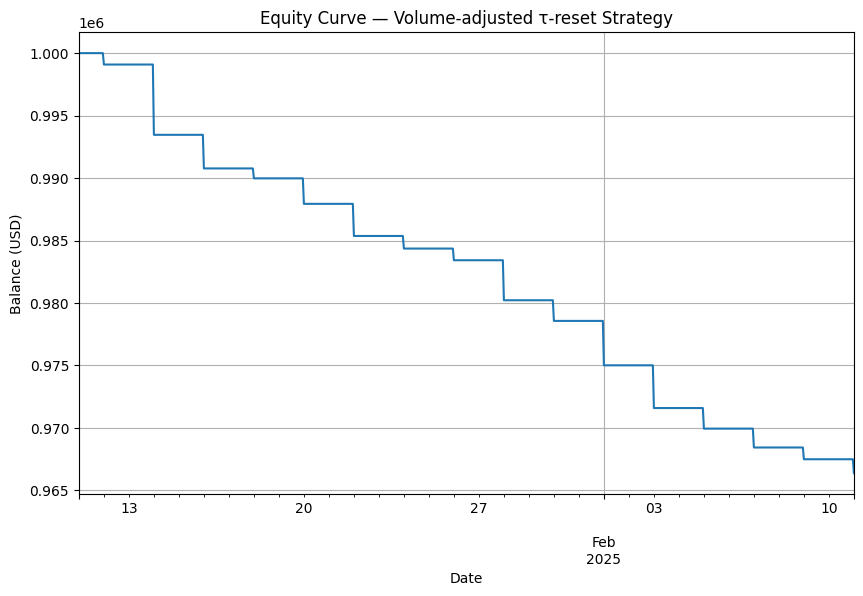

In [73]:
import matplotlib.pyplot as plt

df = result.to_dataframe()

plt.figure(figsize=(10, 6))
df['balance'].plot(title='Equity Curve — Volume-adjusted τ-reset Strategy')
plt.xlabel('Date')
plt.ylabel('Balance (USD)')
plt.grid(True)
plt.savefig("equity_curve_volume_strategy.png")
plt.show()